In [1]:
import sys
import os
import warnings
import tempfile
import pandas as pd
warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src/violin/')))

In [2]:
model_file = 'input/modelA_biorecipe.xlsx'
reading_file = 'input/RA2_0_1_1_reading_biorecipe2.xlsx'
out_file = 'output/RA2_0_1_1'

In [3]:
###Preamble###
%load_ext autoreload
%autoreload 2

from in_out import input_biorecipes,input_reading,output, biorecipe_to_violin
from scoring import score_reading
from network import node_edge_list
from formatting import convert_reading
from visualize_violin import visualize
from utils import *

In [4]:
###Parameters###
 
#Scoring values defined
kind_dict = {"strong corroboration" : 2, 
                "weak corroboration1" : 1,
                "weak corroboration2" : 1,
                "weak corroboration3" : 1,
                "hanging extension" : 40, 
                "full extension" : 40, 
                "internal extension" : 40, 
                "specification" : 30, 
                "dir contradiction" : 10,
                "sign contradiction" : 10,
                "att contradiction" : 10,
                "flagged1" : 20,
                "flagged2" : 20,
                "flagged3" : 20}
match_dict = {"source present" : 1, 
                "target present" : 100, 
                "both present" : 10, 
                "neither present" : 0.1}
#These column names are the attributes used to determine 
#duplicate interactions in evidence_score()
evidence_score_cols = ['Element Name','Element Type','Element ID','Location',
                       'Location ID','Cell Line','Cell Type','Organism',
                       'Positive Reg Name','Positive Reg Type','Positive Reg ID',
                       'Positive Reg Location','Positive Reg Location ID',
                       'Negative Reg Name','Negative Reg Type','Negative Reg ID',
                       'Negative Reg Location','Negative Reg Location ID','Connection Type']
#Attributes Compared
attributes = ['Location ID']   
 

In [5]:
###_Format wrapping_###

model_tf = tempfile.NamedTemporaryFile(suffix='.xlsx')
reading_tf = tempfile.NamedTemporaryFile(suffix='.xlsx')
norm_model(model_file, model_tf)
reading_df = biorecipe_to_violin(reading_file)
reading_df.to_excel(reading_tf, index=False)

In [7]:
###_File input and formatting_###
###This assumes the input files match the default input REACH and BioRECIPES formats###

model_df = input_biorecipes(model_tf.name)

#reading_df, reading_cols = input_reading(VIOLIN_reading=reading_file, evidence_score_cols=evidence_score_cols, atts = attributes)
reading_df, reading_cols = input_reading(reading=reading_tf.name, evidence_score_cols=evidence_score_cols, atts = attributes)

graph = node_edge_list(model_df)

In [9]:
###_Scoring_###

scored = score_reading(reading_df,model_df,graph,reading_cols,kind_values = kind_dict,match_values = match_dict,attributes = attributes)

813


In [10]:
###_Output_###

output(scored,out_file,kind_values=kind_dict)

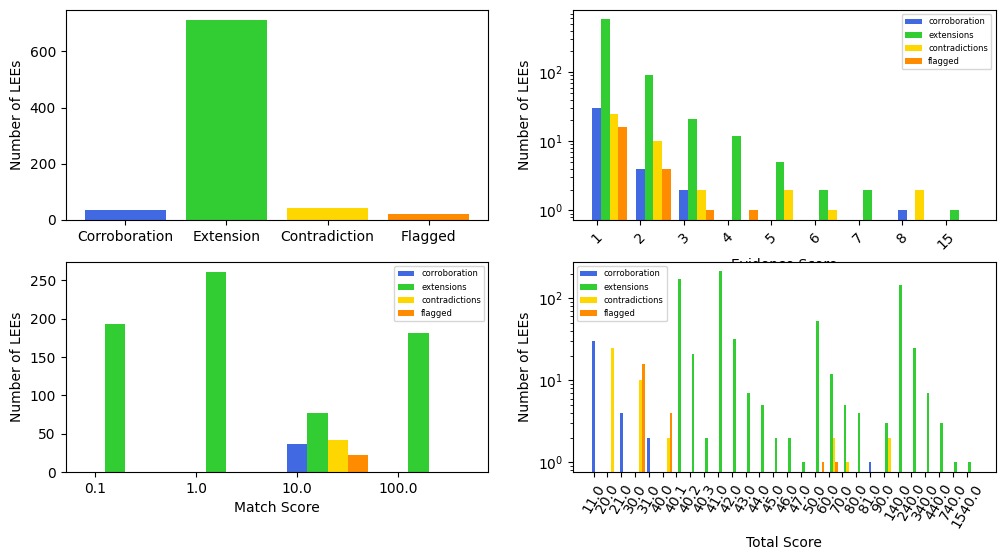

In [11]:
###_Visualization_###
visualize(match_dict, kind_dict, out_file+'_outputDF.csv', filter_opt='100%')

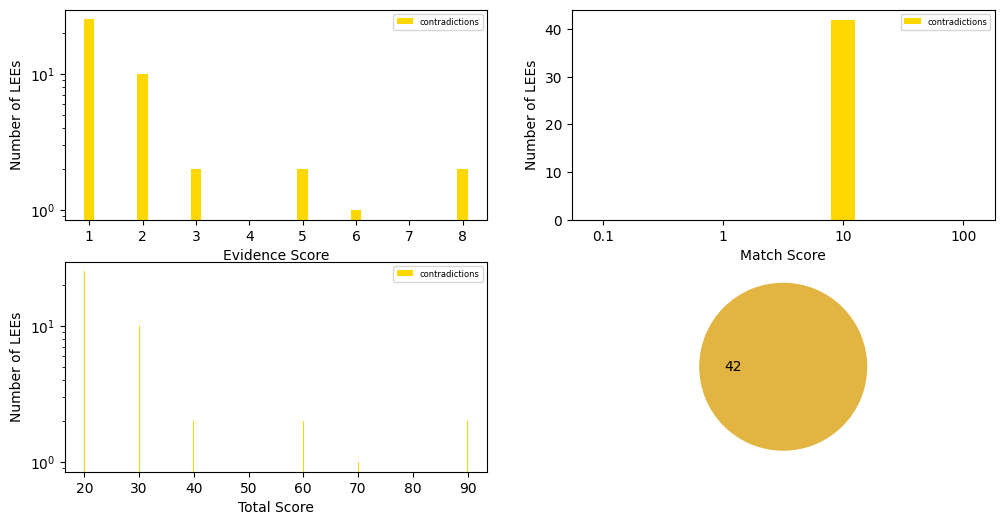

In [12]:
visualize(match_dict, kind_dict, out_file+'_contradictions.csv', filter_opt='100%')

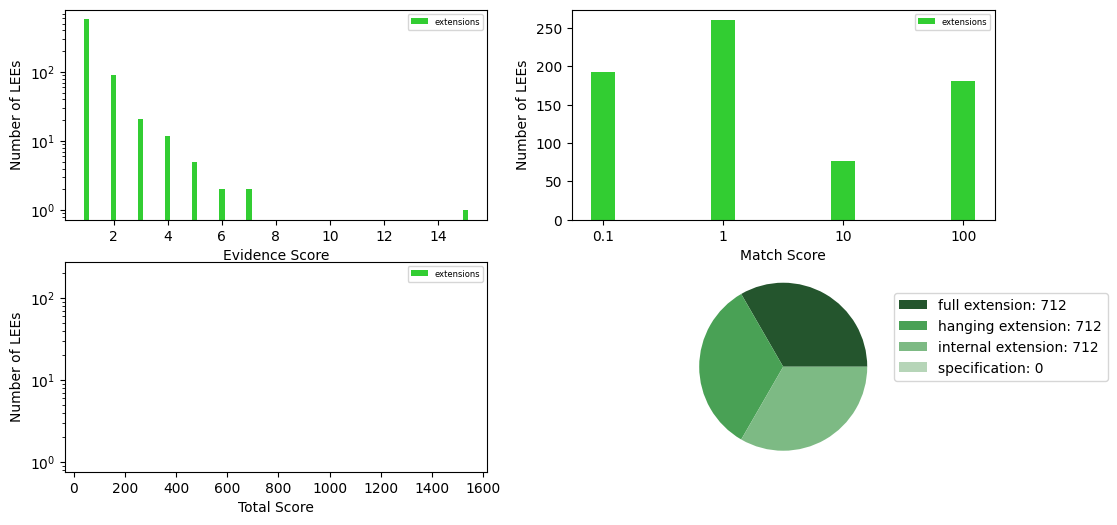

In [13]:
visualize(match_dict, kind_dict, out_file+'_extensions.csv', filter_opt='100%')

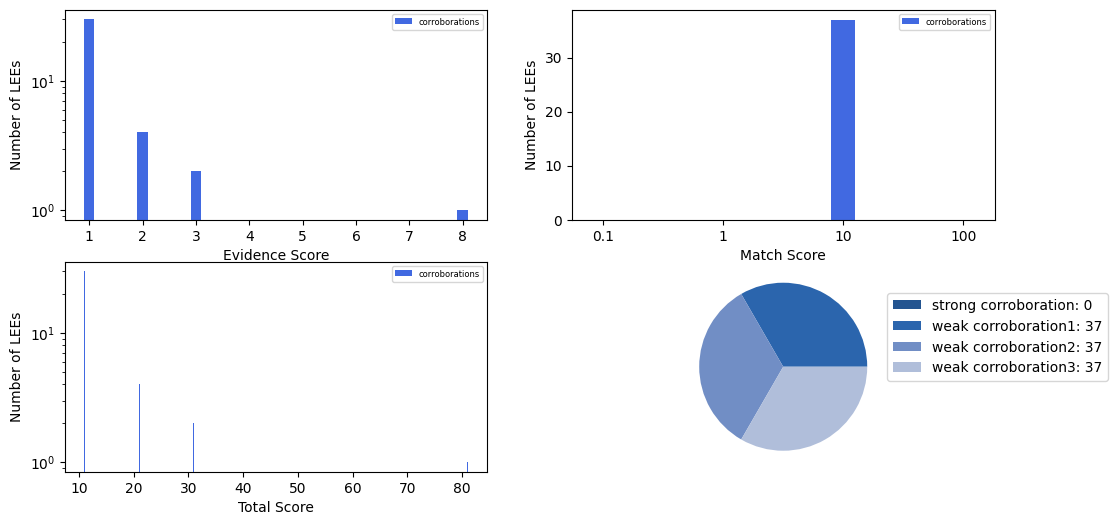

In [14]:
visualize(match_dict, kind_dict, out_file+'_corroborations.csv', filter_opt='100%')